In [125]:
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np

In [191]:
class ArmParams():
    def __init__(self):
        """
        """
        # Define physical properties of arm model
        #TODO: Make this an argument
        # arm lengths
        self.L1, self.L2 = 0.30, 0.30 #m
        # arm masses
        M1, M2 = 1.4, 1.0 #kg
        # moments of inertia
        I1, I2 = .025, .045 #kg/m^2
        # center of mass for lower arm
        D2 = .16 #m

        # constants for dynamics
        self.a1 = I1 + I2 + (M2*self.L1**2)
        self.a2 = (M2*self.L1*D2)
        self.a3 = I2

        # Constant damping matrix
        self.B = jnp.array(
            [(.05, .025),
            (.025, .05)]
        )
        
        # step size
        self.dt = .001


# Define functions to calculate matrices for forward dynamics
def calc_dyn_mats(state, arm_params):
    """
    """
    # extract state vars
    theta1, theta2, dtheta1, dtheta2 = state.squeeze().tolist()
    # Update Matrix of inertia
    m_theta = jnp.array(
        [(arm_params.a1+2*arm_params.a2*jnp.cos(theta2), arm_params.a3+arm_params.a2*jnp.cos(theta2)),
        (arm_params.a3+arm_params.a2*jnp.cos(theta2), arm_params.a3)]
    )
    # Update Centripetal and Coriolis forces
    C = (arm_params.a2*jnp.sin(theta2)) * jnp.array(
        [(-dtheta2*(2*dtheta1+dtheta2)), (dtheta1**2)]
    ).reshape(-1,1)
    
    return m_theta, C

# Define function for calculating arm positions
def calc_arm_pos(thetas, arm_params):
    """
    """
    # Exrtact necessary state vars
    theta1, theta2 = thetas.squeeze().tolist()
    # Calculate positions and return
    elbow_pos = jnp.array([
        (arm_params.L1*jnp.cos(theta1)), (arm_params.L1*jnp.sin(theta1))
    ])
    hand_pos = jnp.array(
        [(elbow_pos[0].item() + arm_params.L2*jnp.cos(theta1+theta2)),
         (elbow_pos[1].item() + arm_params.L2*jnp.sin(theta1+theta2))]
    )
    
    return jnp.vstack([hand_pos, elbow_pos])

# Define dynamics step
def arm_step(torques, state, arm_params):
    """
    """
    # Extract angles for updating arm positions
    theta1, theta2, dtheta1, dtheta2 = state.squeeze().tolist()
    dthetas = jnp.array([(dtheta1), (dtheta2)]).reshape(-1, 1)
    # Update dynamics matrices
    m_theta, C = calc_dyn_mats(state, arm_params)
    # Forward dynamics of torques applied to arm
    d2thetas = jnp.linalg.inv(m_theta) @ (torques - C + (arm_params.B@dthetas))
    # New state
    dstate = jnp.vstack([dthetas, d2thetas])

    # Update state (TODO: May want to use a more powerful integration method)
    n_state = state + arm_params.dt*dstate

    # Calculate new arm positions (hand and elbow)
    arm_pos = calc_arm_pos(n_state[:2], arm_params)
    
    return n_state, arm_pos
    

In [192]:
arm_params = ArmParams()
init_state = jnp.zeros((4,1))*1.
torques = jnp.ones((2,1)) * 10 

In [193]:
n_state, arm_pos = arm_step(torques, init_state, arm_params)

In [194]:
n_state

Array([[ 0.        ],
       [ 0.        ],
       [-0.16718918],
       [ 0.5677466 ]], dtype=float32)

In [197]:
arm_pos

Array([[0.6, 0. ],
       [0.3, 0. ]], dtype=float32)

In [243]:
def init_radial_targets(arm_params, init_pos=[0.4, 0.25], radius=0.12):
    # Set starting positions
    x0, y0 = init_pos
    
    # Get target locations
    target_angles = jnp.array([0., 45., 90., 135., 180., 225., 270., 315.])*(2*jnp.pi/360)
    target_x = x0 + (jnp.cos(target_angles)*radius)
    target_y = y0 + (jnp.sin(target_angles)*radius)
    targets = jnp.concat([target_x[:, None], target_y[:, None]], axis=1)
    
    # Get initial angles
    theta1 = np.arctan2(y0, x0) - np.arccos((x0**2 + y0**2 + arm_params.L1**2 - arm_params.L2**2)
                                                     /(2*arm_params.L1*(x0**2 + y0**2)**0.5))
    theta2 = np.arccos((x0**2 + y0**2 - arm_params.L1**2 - arm_params.L2**2)/(2*arm_params.L1*arm_params.L2))
    thetas = jnp.vstack([theta1, theta2])
    
    # Get elbow and arm pos
    init_arm_pos = calc_arm_pos(thetas, arm_params)

    return targets, init_arm_pos, thetas

In [244]:
targets, init_arm_pos, thetas = init_radial_targets(arm_params)

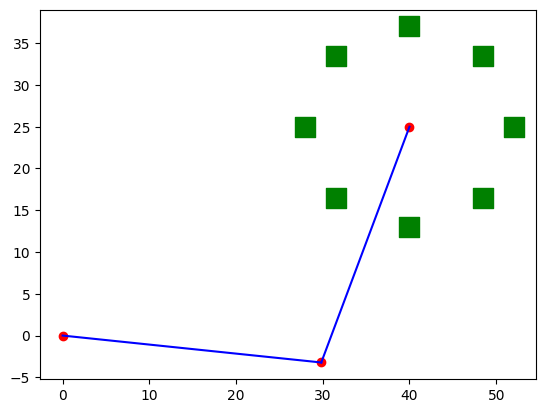

In [250]:
fig = plt.figure()
# Target locations
plt.scatter(targets[:, 0]*100, targets[:, 1]*100, marker='s', color='green', s=200) #TODO, figure out how big these need to be

# Start Locations
plt.scatter(0., 0., color='red') # Shoulder
plt.scatter(init_arm_pos[0, 0]*100, init_arm_pos[0, 1]*100, color='red') # Hand
plt.scatter(init_arm_pos[1, 0]*100, init_arm_pos[1, 1]*100, color='red') # Elbow

# Make arms by connecting joints
plt.plot([0., init_arm_pos[1, 0]*100], [0., init_arm_pos[1, 1]*100], color='blue') # Lower Arm
plt.plot(
    [init_arm_pos[0, 0]*100, init_arm_pos[1, 0]*100],
    [init_arm_pos[0, 1]*100, init_arm_pos[1, 1]*100], color='blue')